## **Import dependencies**

In [1]:
# Import SSS dependencies
import sss
from sss.base import default_db_file, AutomappedDB
from sss import SSS
from sqlalchemy import create_engine 

# Import dependencies to create a plot
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## **Connect to Database**

In [2]:
# Connect to database
db = AutomappedDB(db_file = '/Users/azizamirsaidova/Desktop/sss.sqlite')
# Start a session
session = db.sessionmaker()

## **Create a query and dataframe**

In [3]:
query = session.query(SSS).filter(SSS.year == 2020)
df = pd.read_sql(query.statement, db.engine)

In [5]:
# Creating a query using SQL
sql = 'select * from self_sufficiency_standard where year == 2020'

# Creating a dataframe from SQL query
dfw = pd.read_sql(sql, con=db.engine)

In [6]:
# Since we get the values for only year 2020, we only have year 2020 values
dfw.year.value_counts()

2020    74776
Name: year, dtype: int64

### **Main family types used in our analysis**

1 Adult -> a1i0p0s0t0

1 Adult 1 Preschooler -> a1i0p1s0t0

1 Adult 1 Preschooler + 1 Schoolage -> a1i0p1s1t0

2 Adults & 1 Preschooler + 1 Schoolage -> a2i0p1s1t0

2 Adults & 1 Infant + 1 Preschooler + 1 Schoolage -> a2i1p1s1t0



## **Pre-process the data to prepare for analysis**

In [7]:
# Only choose the state WA and CA for our analysis
final = dfw[dfw['state'].isin(['WA', 'CA'])]

# Choosing only three main family types
wa_1adult = final[final['family_type'].isin(['a1i0p0s0t0', 'a1i0p1s0t0', 'a1i0p1s1t0'])]

# Choosing only King and San Francisco County
wa_1adult = wa_1adult[wa_1adult['place'].isin(['King County (Seattle)', 'San Francisco County'])]

# Consolidate the columns and choose the columns that you only need
wa_1adult = wa_1adult[['family_type','place','annual_self_sufficiency_wage', 'year']]

In [8]:
# Gender Wage gap data from Census
# Reading a new file and conducting pre-processing of the values
cs = pd.read_csv('/Users/azizamirsaidova/Downloads/gender_wage_seattle.csv')
cs = cs.rename(columns = {'Seattle city, Washington!!Estimate': 'estimate', 'Seattle city, Washington!!Margin of Error':'moe', 'Label (Grouping)':'label'})

gender = ['Male', 'Female']
gd = cs[cs['label'].str.contains('|'.join(gender))] 
gd.estimate = [val.replace(',','') for val in gd.estimate.values]
gd.estimate = gd.estimate.astype(int)
gd

,label,estimate,moe
6,Male:,73415,"±1,970"
12,Female:,56199,"±1,154"


In [9]:
# Considering two dataframes: gender and wage gap has a different length of values per column. We created one csv file merging these two dataframes
updated = pd.read_csv('/Users/azizamirsaidova/data_for_wage.csv')
updated

,family_type,place,annual_self_sufficiency_wage,year
0,a1i0p0s0t0,San Francisco County,55505.49,2020
1,a1i0p1s0t0,San Francisco County,108529.82,2020
2,a1i0p1s1t0,San Francisco County,132285.84,2020
3,a1i0p0s0t0,King County (Seattle),36064.73,2020
4,a1i0p1s0t0,King County (Seattle),69215.38,2020
5,a1i0p1s1t0,King County (Seattle),82044.82,2020
6,Male,King County (Seattle),73415.00,2020
7,Female,King County (Seattle),56199.00,2020
8,Male,San Francisco County,73415.00,2020
9,Female,San Francisco County,56199.00,2020


## **Create Visualization to plot Gender Wage gap**

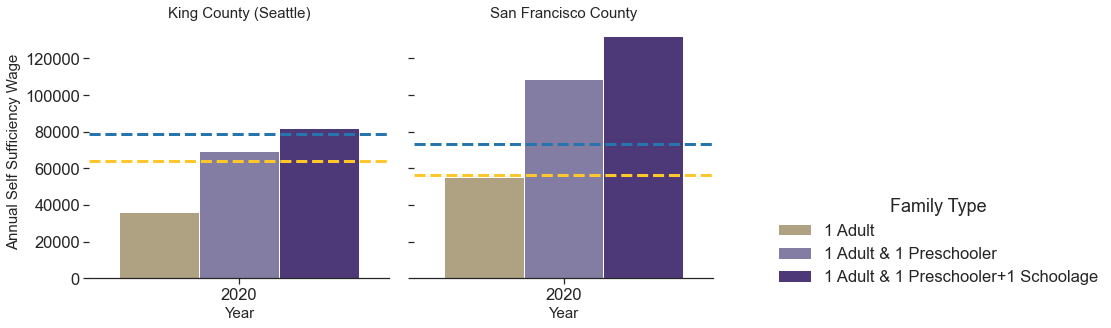

In [10]:
sns.set(font_scale=1.5)
sns.set_style('ticks')

# Create a categorical plot which lists two cities together
g = sns.catplot(x="year", y="annual_self_sufficiency_wage",
                hue="family_type", 
                col="place",
                data=wa_1adult, kind="bar",col_wrap=3,
                height=5, aspect=1,
                palette = ['#B7A57A','#7E76AA','#4B2E83']);

(g.set_axis_labels("Year", "Annual Self Sufficiency Wage",size=15)
.set_titles("{col_name}",size=15)
.despine(left=True))

# Add a line for gender wage gap highlight
axes = g.axes.flatten()
axes[1].axhline(73415.00, ls='--', linewidth=3, color='#2774ae')
axes[1].axhline(56199.00, ls='--', linewidth=3, color='#ffc72c')

axes[0].axhline(78873, ls='--', linewidth=3, color='#2774ae')
axes[0].axhline(64020, ls='--', linewidth=3, color='#ffc72c')


# Add a Family Type legend
new_title = 'Family Type'
g._legend.set_title(new_title)
new_labels = ['1 Adult', '1 Adult & 1 Preschooler','1 Adult & 1 Preschooler+1 Schoolage']
for t, l in zip(g._legend.texts, new_labels):
   t.set_text(l)
sns.move_legend(g, "upper left", bbox_to_anchor=(.65, .45))


In [540]:
# Save a file with transparent background
g.savefig('Downloads/gender_comp.svg',dpi=500,transparent=True)